In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from seaborn import regplot
from qbstyles import mpl_style

mpl_style(dark=False)

In [2]:
from argparse import ArgumentParser
import sqlite3
from os import path
import pandas as pd

class Filter:
    guide_keywords = ['book', 'guide', 'synthes', 'manufacture', 'homemade', 'bundle', 'how to', 'tutorial', 'manual']

    @staticmethod
    def filter_custom_listings(df):
        custom_listings = df[
            df.title.str.lower().str.contains('custom')
        ]

        item_hashes = custom_listings.groupby('item_hash').filter(lambda x: len(x) <= 1)
        return df[~df.item_hash.isin(item_hashes['item_hash'])]

    @staticmethod
    def filter_drug_listings(dfItems):
        drug_keywords = [
            'alprazolam', 'hulk', 'percocet', 'pfizer', 'tavor', '0mg', '0 mg', '5mg', '5 mg', '0ug', '0 ug', 
            '5ug', '5 ug', 'µ', 'glue', 'preroll', 'pre-roll', 'ferrari', 'tesla', 'calvin klein', 'methyl', 
            'kush', 'amphetamine', 'mdma', '4fa', 'viagra', 'captagon', 'blotter', 'pill', 'microdot', '2c-', 
            'ambien', 'olam', 'epam', 'blunt', 'fentanyl', 'pvp', 'oxycodone', 'xanax', 'tablets'
        ]

        df_guide_items = dfItems[dfItems['title'].str.lower().str.contains('|'.join(Filter.guide_keywords))]

        df_drug_related_items = dfItems[dfItems['title'].str.lower().str.contains('|'.join(drug_keywords))]
        df_drug_items = df_drug_related_items[~df_drug_related_items.index.isin(df_guide_items.index)]

        dfItems = dfItems[~dfItems.index.isin(df_drug_items.index)]
        dfItems = dfItems[dfItems['category'] != 'other - custom']

        return dfItems

    @staticmethod
    def filter_misc(df):
        misc_keywords = ['tip jar', 'cyanid']

        df_misc_items = df[df['title'].str.lower().str.contains('|'.join(misc_keywords))]

        return df[~df.index.isin(df_misc_items.index)]

    @staticmethod
    def filter_guns(df):
        df_guide_items = df[df['title'].str.lower().str.contains('|'.join(Filter.guide_keywords))]
        
        gun_keywords = [
            'magnum', 'glock', 'stungun', 'stun gun', 'airsoft', 'ammunition', 'rounds'
        ]

        df_gun_items = df[df['title'].str.lower().str.contains('|'.join(gun_keywords)) | df['description'].str.lower().str.contains('|'.join(gun_keywords))]
        df_exclude = df_gun_items[~df_gun_items.index.isin(df_guide_items.index)]

        return df[~df.index.isin(df_exclude.index)]

    @staticmethod
    def separate_carding(df):
        carding_keywords = [
            'cvv', 'fullz', 'fulls', 'carding', 'vbv', 'avs', 'visa', 'mastercard', 'amex', 'ccv', 'pizza', 'slice', ' cc '
        ]

        non_carding_indicators = [
            'vps', 'rdp', 'anonymous', 'anon', 'reloadable', 'server'
        ]

        carding_categories = [
            'cash-out', 'other - account', 'other - guide', 'other'
        ]

        df_carding_items = df[(df['category'].isin(carding_categories)) & (df['title'].str.lower().str.contains('|'.join(carding_keywords)))]
        df_carding_items = df_carding_items[~df_carding_items['title'].str.lower().str.contains('|'.join(non_carding_indicators))]

        df.loc[df.index.isin(df_carding_items.index), 'category'] = 'carding'
        
        return df

    @staticmethod
    def apply_all_filters(df):
        print(f"Size before filter: {df.shape[0]}")

        df = Filter.filter_custom_listings(df)
        print(f"Size after filtering custom listing: {df.shape[0]}")

        df = Filter.filter_drug_listings(df)
        print(f"Size after filtering drugs: {df.shape[0]}")

        df = Filter.filter_misc(df)
        print(f"Size after filtering misc: {df.shape[0]}")

        df = Filter.filter_guns(df)
        print(f"Size after filtering guns: {df.shape[0]}")

        df = Filter.separate_carding(df)

        return df

def load_dataset(location):
    connection = sqlite3.connect(location)

    df = pd.read_sql("SELECT * FROM feedbacks left join items on feedbacks.item_hash = items.item_hash", connection)
    # remove duplicated columns
    df = df.loc[:, ~df.columns.duplicated()]
    # convert bytestrings
    df['giver_hash'] = df['giver_hash'].str.decode("utf-8")
    df['receiver_hash'] = df['receiver_hash'].str.decode("utf-8")
    df['vendor_hash'] = df['vendor_hash'].str.decode("utf-8")
    # convert timestamps
    df['date'] = pd.to_datetime(df['date'])
    df['first_observed'] = pd.to_datetime(df['first_observed'])
    df['last_observed'] = pd.to_datetime(df['last_observed'])
    # close connection
    connection.close()

    return df

df = load_dataset('../../data/underground_cyber.sqlite3')
df = Filter.apply_all_filters(df)

Size before filter: 564204
Size after filtering custom listing: 560002
Size after filtering drugs: 530411
Size after filtering misc: 528320
Size after filtering guns: 527525


In [3]:
# Total revenue per month
df_rev = df[['date', 'order_amount_usd']]
df_rev = df_rev.sort_values(by='date')
df_rev['date'] = pd.DatetimeIndex(df_rev['date']).to_period('M')
df_rev_bymonth = df_rev.groupby('date').sum()
df_rev_bymonth.index = df_rev_bymonth.index.to_timestamp()
df_rev_bymonth

,order_amount_usd
date,
2011-06-01,65.38
2011-07-01,909.39
2011-08-01,7109.93
2011-09-01,11489.13
2011-10-01,6846.74
...,...
2017-01-01,463000.77
2017-02-01,446750.22
2017-03-01,595441.33


In [5]:
# Monthly articles
df_media = df_media = pd.read_csv('../../data/news_coverage.csv')[['date', 'count']]
df_media['date'] = pd.to_datetime(df_media['date'], format="%Y-%m-%d")
df_media = df_media.sort_values(by='date').reset_index(drop=True)
df_media['date'] = pd.DatetimeIndex(df_media['date']).to_period('M')
df_media_bymonth = df_media.groupby('date').sum()
df_media_bymonth = df_media_bymonth[str(df_rev_bymonth.index.min()-pd.DateOffset(months=1)):str(df_rev_bymonth.index.max())]
df_media_bymonth.index = df_media_bymonth.index.to_timestamp()
df_media_bymonth

,count
date,
2011-05-01,59
2011-06-01,152
2011-07-01,65
2011-08-01,76
2011-09-01,65
...,...
2017-01-01,529
2017-02-01,405
2017-03-01,681


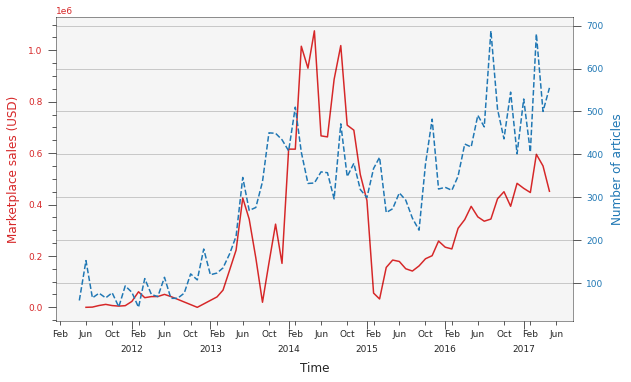

In [9]:
fig, ax1 = plt.subplots()

x1 = df_rev_bymonth.index
y1 = df_rev_bymonth['order_amount_usd']

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Marketplace sales (USD)', color=color)
ax1.plot(x1, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_facecolor('#f5f5f5')
plt.grid()
# ax1.set_title("Monthly Revenue Against Number of Monthly Articles About Darknet Markets")


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
x2 = df_media_bymonth.index
y2 = df_media_bymonth['count']
color = 'tab:blue'
ax2.set_ylabel('Number of articles', color=color)  # we already handled the x-label with ax1
ax2.plot(x2, y2, color=color, linestyle='dashed')
ax2.tick_params(axis='y', labelcolor=color)

# ax1.vlines(x=pd.to_datetime('October 2013'), ymin=min(y1), ymax=max(y1), linestyles='dashed', colors=['orange'])
# ax1.text(pd.to_datetime('August 2013'), max(y1)-max(y1)/4, 'SR1 take-down', rotation=90, va='center', color='orange')
# ax1.vlines(x=pd.to_datetime('November 6 2014'), ymin=min(y1), ymax=max(y1), linestyles='dashed', colors=['orange'])
# ax1.text(pd.to_datetime('December 2014'), max(y1)-max(y1)/4, 'Operation Onymous', rotation=90, va='center', color='orange')

# set major ticks location every day
ax1.xaxis.set_major_locator(mdates.YearLocator())
# set major ticks format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))
# set minor ticks location every two hours
ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=4))
# set minor ticks format
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_size_inches(10, 6)
plt.savefig('articles_vs_revenue.pdf')
plt.show()

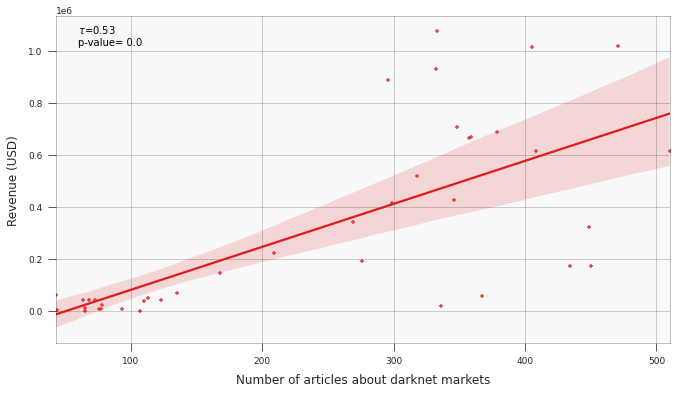

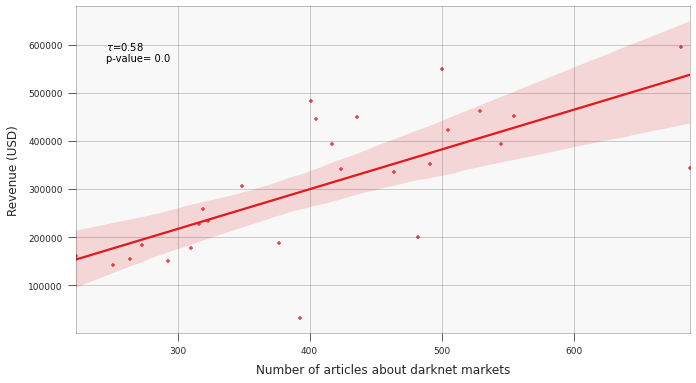

In [7]:
def render(nextmonth=False):
    df1 = df_rev_bymonth.copy()
    df2 = df_media_bymonth.copy()
    df3 = df1.merge(df2, on='date').sort_values(by='date')
    
    if nextmonth:
        df3['count'] = df3['count'].shift(1)

    df3 = df3[1:]
    for i in range(2):
        df_corr = df3.copy().fillna(0)
        if i == 0:
            title = 'pre-February 2015'
            period = 'prefeb2015'
            df_corr = df_corr[df_corr.index <= pd.to_datetime('February 1 2015')]
        else:
            title = 'post-February 2015'
            period = 'postfeb2015'
            df_corr = df_corr[df_corr.index > pd.to_datetime('February 1 2015')]
        df_corr.corr(method='kendall')

        x = df_corr['count'].tolist()
        y = df_corr['order_amount_usd'].tolist()
        corr, p_value = stats.kendalltau(x, y)
        plt.figure(figsize=(11,6))
        ax = regplot(x=x, y=y, marker="+")
        ax.set(xlabel='Number of articles about darknet markets', ylabel='Revenue (USD)', title='')
#         ax.set_title(f'Correlation Between Media Coverage of Darknet Markets and Same Month Revenue ({title})', y=1.04)
#         if nextmonth:
#             ax.set_title(f'Correlation Between Media Coverage of Darknet Markets and Next Month Revenue ({title})', y=1.04)
        ax.text(min(x)+max(x)/30, max(y)-max(y)/20, r'$\tau$=' + str(round(corr, 2)) + '\np-value= ' + str(round(p_value, 2)))
        
        plt.savefig(f'overall_mediacoverage_{period}_samemonth.pdf')
        if nextmonth:
            plt.savefig(f'overall_mediacoverage_{period}_nextmonth.pdf')

        plt.show()
        
render()

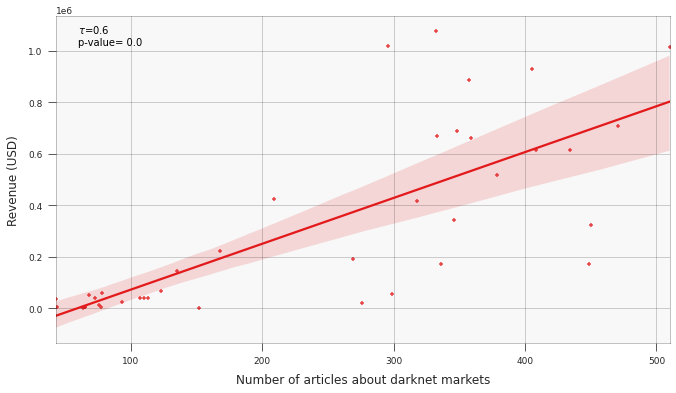

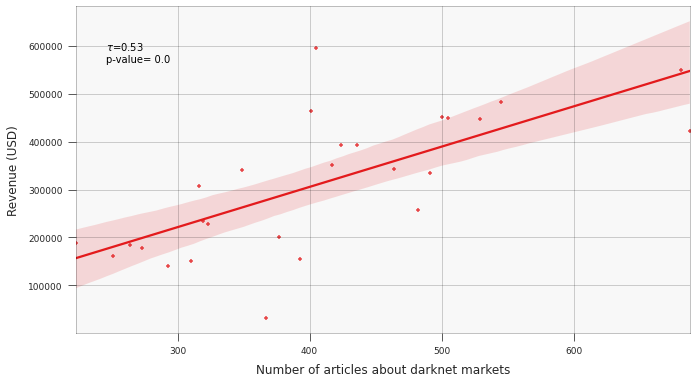

In [8]:
render(True)